In [1]:
import torch
import torchvision
import os
import sys
import numpy as np
import submitit
from tqdm import trange
from collections import defaultdict
from pathlib import Path
from speedrun import BaseExperiment, WandBMixin, IOMixin, register_default_dispatch
from torch_db import Tracer
import matplotlib.pyplot as plt
from jumping_quadrupeds.buffer import ReplayBufferStorage
from jumping_quadrupeds.env import make_env
from jumping_quadrupeds.utils import DataSpec, preprocess_obs, set_seed, buffer_loader_factory
from jumping_quadrupeds.ppo.agent import PPOAgent
from jumping_quadrupeds.drqv2.agent import DrQV2Agent
from jumping_quadrupeds.spr.agent import SPRAgent
from jumping_quadrupeds.mae.agent import MAEAgent
from jumping_quadrupeds.train import Trainer
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange



In [2]:
os.chdir("..")
%matplotlib inline

In [3]:
# helpers
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    


In [4]:
EXP = "hard-car-mae-exp-1"
# CKPT_NAME = "checkpoint_best"

In [5]:
trainer = Trainer(skip_setup=True)
trainer.experiment_directory = f"experiments/{EXP}"


In [6]:
print(trainer.get("env/kwargs"))

None


In [11]:
trainer.read_config_file()
trainer.set("use_wandb", False)
# trainer.record_args()

In [12]:
# env setup
seed = set_seed(seed=trainer.get("seed"))
trainer.env = make_env(seed=seed, **trainer.get("env/kwargs"))
trainer.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer._build_agent()


In [14]:
trainer.get("env")

{'kwargs': {'action_repeat': 1,
  'max_ep_len': 1000,
  'name': 'gym-CarRacingManualConeObstacles-v0',
  'render_every': 25}}

In [15]:
trainer.agent.load_checkpoint(trainer.experiment_directory, 700000)

loading checkpoint: 700000


RuntimeError: Error(s) in loading state_dict for Actor:
	size mismatch for trunk.0.weight: copying a param with shape torch.Size([50, 25088]) from checkpoint, the shape in current model is torch.Size([50, 3136]).

In [13]:
trainer.agent.encoder.decoder

Transformer(
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fn): Attention(
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=64, out_features=768, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=256, out_features=64, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (1): PreNorm(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): GELU()
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=256, out_features=64, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
  )
)

In [14]:
num_train_params = sum(param.numel() for param in trainer.agent.encoder.parameters() if param.requires_grad)
num_nontrain_params = sum(param.numel() for param in trainer.agent.encoder.parameters() if not param.requires_grad)
print(f'Trainable params: {num_train_params}')
print(f'Untrainable params: {num_nontrain_params}')
print(f'Total number of params: {num_train_params + num_nontrain_params}')

Trainable params: 255512
Untrainable params: 0
Total number of params: 255512


In [10]:
obs = trainer.env.reset()
with Tracer(detach=True).trace(trainer.agent.encoder) as tracer:
    for i in range(31):
        x = preprocess_obs(obs, trainer.device)
        action, val, logp = trainer.agent.act(x, trainer.step, eval_mode=False)
        obs, reward, done, misc = trainer.env.step(action)

Track generation: 1055..1332 -> 277-tiles track


/home/martin/Applications/anaconda3/envs/jumping_quadrupeds/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


ValueError: could not convert string to float: 'linear'

In [13]:
loss, pred_pixel_values, masked_indices, unmasked_indices, patches = trainer.agent.encoder(x.unsqueeze(0), eval=False)

/home/martin/Applications/anaconda3/envs/jumping_quadrupeds/lib/python3.8/site-packages/torch/nn/modules/module.py:964: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "


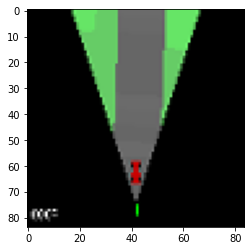

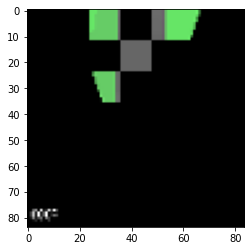

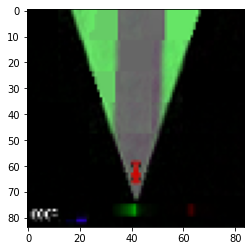

In [14]:

def visualize(pred_pixel_values, patches, seq_len=3, sample_id=0):
    masked_patch_pred = pred_pixel_values[sample_id].detach().cpu()
    masked_patch_true = patches[sample_id].cpu()

    pred_patches = rearrange(masked_patch_pred, 'p (h w c) -> p c h w', c=3, h=12, w=12)
    gt_patches = rearrange(masked_patch_true, '(p s) (h w c) -> (p s) c h w', c=3, h=12, w=12, s=seq_len)

    pred_recons = gt_patches.clone()
    pred_w_mask = gt_patches.clone()
    pred_recons[masked_indices[sample_id]] = pred_patches
    pred_w_mask[masked_indices[sample_id]] = 0.

    pred_recons = rearrange(pred_recons, '(s p1 p2) c h w -> s c (p1 h) (p2 w)', p1=7, p2=7, c=3, h=12, w=12, s=seq_len)
    pred_w_mask = rearrange(pred_w_mask, '(s p1 p2) c h w -> s c (p1 h) (p2 w)', p1=7, p2=7, c=3, h=12, w=12, s=seq_len)

    imshow(torchvision.utils.make_grid(torch.tensor(obs)))
    imshow(torchvision.utils.make_grid(pred_w_mask, nrow=7 * seq_len))
    imshow(torchvision.utils.make_grid(pred_recons.clip(0, 1), nrow=7))
    
visualize(pred_pixel_values, patches, seq_len=1, sample_id=0)

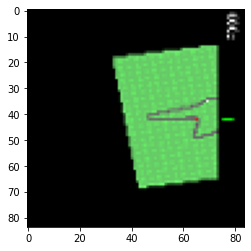

In [15]:

plt.imshow(x.T.cpu())

In [5]:
x.mean()

tensor(0.1431, device='cuda:0')

In [9]:
tracer.records.get('encoder.transformer')['output'].abs().mean()

tensor(0.9049, device='cuda:0')

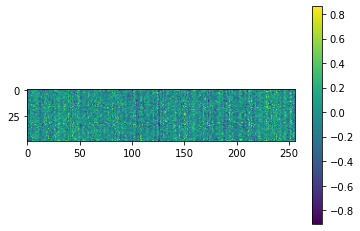

In [7]:
out1 = tracer.records.get('encoder.transformer.layers.3.1')['output'].squeeze(0)
plt.figure()
plt.imshow(out1.cpu())
plt.colorbar()
plt.show()

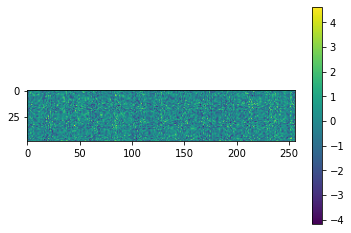

In [8]:
out2 = tracer.records.get('encoder.transformer')['output'].squeeze(0)
plt.figure()
plt.imshow(out2.cpu())
plt.colorbar()
plt.show()

In [51]:
tracer.records.get('encoder.transformer')['input'][0]

tensor(-3.9955, device='cuda:0')

In [ ]:
tracer.records.keys()

dict_keys(['encoder.to_patch_embedding.0', 'encoder.to_patch_embedding.1', 'encoder.transformer.layers.0.0.norm', 'encoder.transformer.layers.0.0.fn.to_qkv', 'encoder.transformer.layers.0.0.fn.attend', 'encoder.transformer.layers.0.0.fn.to_out.0', 'encoder.transformer.layers.0.0.fn.to_out.1', 'encoder.transformer.layers.0.0.fn.to_out', 'encoder.transformer.layers.0.0.fn', 'encoder.transformer.layers.0.0', 'encoder.transformer.layers.0.1.norm', 'encoder.transformer.layers.0.1.fn.net.0', 'encoder.transformer.layers.0.1.fn.net.1', 'encoder.transformer.layers.0.1.fn.net.2', 'encoder.transformer.layers.0.1.fn.net.3', 'encoder.transformer.layers.0.1.fn.net.4', 'encoder.transformer.layers.0.1.fn.net', 'encoder.transformer.layers.0.1.fn', 'encoder.transformer.layers.0.1', 'encoder.transformer.layers.1.0.norm', 'encoder.transformer.layers.1.0.fn.to_qkv', 'encoder.transformer.layers.1.0.fn.attend', 'encoder.transformer.layers.1.0.fn.to_out.0', 'encoder.transformer.layers.1.0.fn.to_out.1', 'encod

In [ ]:
next_obs, reward, done, misc = trainer.env.step(action)

trainer.episode_returns[trainer.ep_idx].append(reward)
trainer.next_step()
trainer.replay_storage.add({"obs": obs, "act": action, "rew": reward, "val": val, "logp": logp})

# Update obs (critical!)
obs = next_obs

if trainer.checkpoint_now:
    trainer.agent.save_checkpoint(trainer.experiment_directory, trainer.step)

if done or trainer.episode_timeout:
    trainer.replay_storage.finish_episode()
    trainer.write_logs()
    trainer.ep_idx += 1
    obs = trainer.env.reset()

if trainer.update_now:
    metrics = trainer.agent.update(trainer.replay_iter, trainer.step)
    if trainer.get("use_wandb"):
        trainer.wandb_log(**metrics)
